In [1]:
# Import modules
import calendar
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from scipy import stats
from scipy.signal import argrelextrema
# Our own modules
from get_waterlevel import download_waterlevel
from multiple_regression_tidal_constituents import multiple_regression

plt.rcParams.update({'font.size': 18})

In [2]:
# Read the information about all water level stations from file
df_stations_info = pd.read_csv('tide_stations_locations.csv', index_col=1)

# Define the stations we are interested in
stations = ['HFT', 'BOO', 'MAY', 'TRG']

# Download water level data for these station from the Norwegian Mapping Authority's API
start_date = '2010-01-01'    # First day for which to download water level data.
end_date = '2021-12-31'      # Last day for which to download water level data.
for station in stations:
    lat = df_stations_info.loc[station]['latitude']
    lon = df_stations_info.loc[station]['longitude']
    #download_waterlevel(start_date, end_date, station, lat, lon)    # Commented out now so it doesn't actually download the data


In [3]:
#-----------------------------------------------------------------------------#
# Look at and describe the data
#-----------------------------------------------------------------------------#

# Define some parameters
year = '2021'       # Limit the analysis to one year

# Initialize dictionaries to hold data
df_stations = {}    # Water level data at the stations

# Read in the water level data
for station in stations:
    #print(f'Performing multiple regression for station {station}')
    df_stations[station] = pd.read_csv(f'{station}_waterlevel.csv', index_col=0, parse_dates=True)
    # Remove the mean waterlevel from the time series
    df_stations[station]['level_demean'] = df_stations[station]['Level'].copy() - df_stations[station]['Level'].mean()
    # Calculate for each observation the number of hours elapsed since the first observation
    df_stations[station]['tk'] = (df_stations[station].index - df_stations[station].index[0]).total_seconds()/(60*60)
    # Select the year we want to analyse
    df_stations[station] = df_stations[station].loc[year]

In [4]:
#--- Check for missing data
obs_per_day = 144    # Theoretically there should be observations every 10 minutes, so 144 per day

# Initialize dictionaries to hold the results of the analysis
obs_per_year = {}
missing_data = {}
# Find the number of observations there should theoretically be for the given year
days_per_year = 366 if calendar.isleap(int(year)) else 365
obs_per_year_theoretical = days_per_year * obs_per_day
for station in stations:
    # Find the number of actual observations
    obs_per_year[station] = df_stations[station]['Level'].count()
    # Calculate the amount of missing data
    missing_data[station] = {
        'Absolute': obs_per_year_theoretical - obs_per_year[station],
        'Realative (%)': 100*(obs_per_year_theoretical - obs_per_year[station])/obs_per_year_theoretical
    }
# Print the amount of missing data
print('Station', '  # missing data', '  % missing data')
for station in stations:
    print( f'{station:5} {missing_data[station]["Absolute"]:10} {missing_data[station]["Realative (%)"]:15}')


Station   # missing data   % missing data
HFT            0             0.0
BOO            0             0.0
MAY            0             0.0
TRG            0             0.0


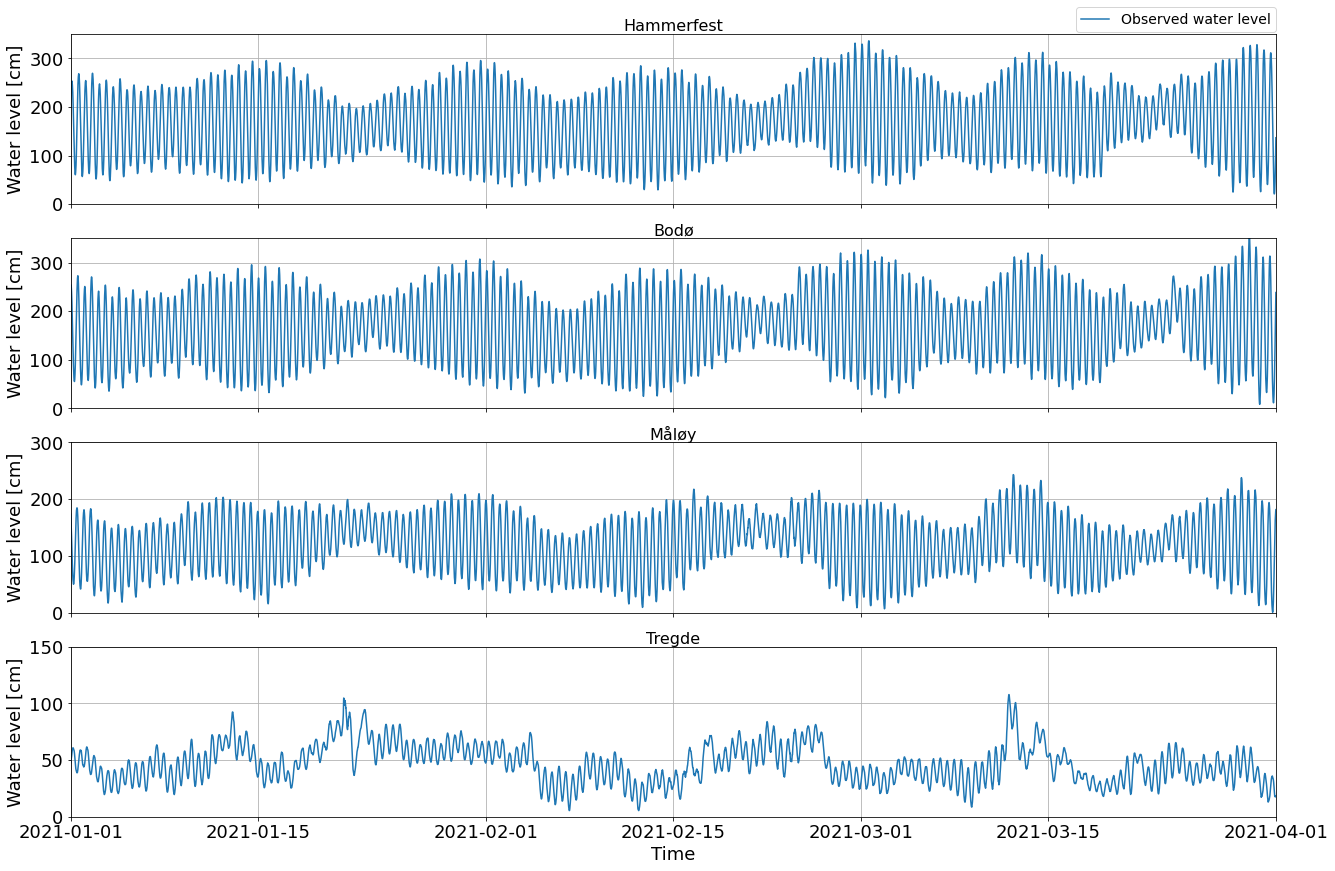

In [5]:
#--- Plot the data for a few months (plotting the whole year will make it impossible to see details)
ymax = [350, 350, 300, 150]    # Max value on y-axis of the plot
fig, axs = plt.subplots(4, 1, sharex='all', figsize=(21.6,14.4))
for i in range(len(stations)):
    # Add a new subplot for this station
    station = stations[i]
    axs[i].plot(df_stations[station]['Level'].loc['2021-01':'2021-03'], label='Observed water level')
    axs[i].set_ylabel('Water level [cm]')
    axs[i].text(0.5, 1, df_stations_info.loc[station]['name'], verticalalignment='bottom',
            horizontalalignment='center', transform=axs[i].transAxes, fontsize=16)
    axs[i].grid(True)
    axs[i].set_ylim([0, ymax[i]])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.917, 1.20), ncol=2, fontsize=14)
axs[-1].set_xlabel('Time')
axs[-1].set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-04-01'));

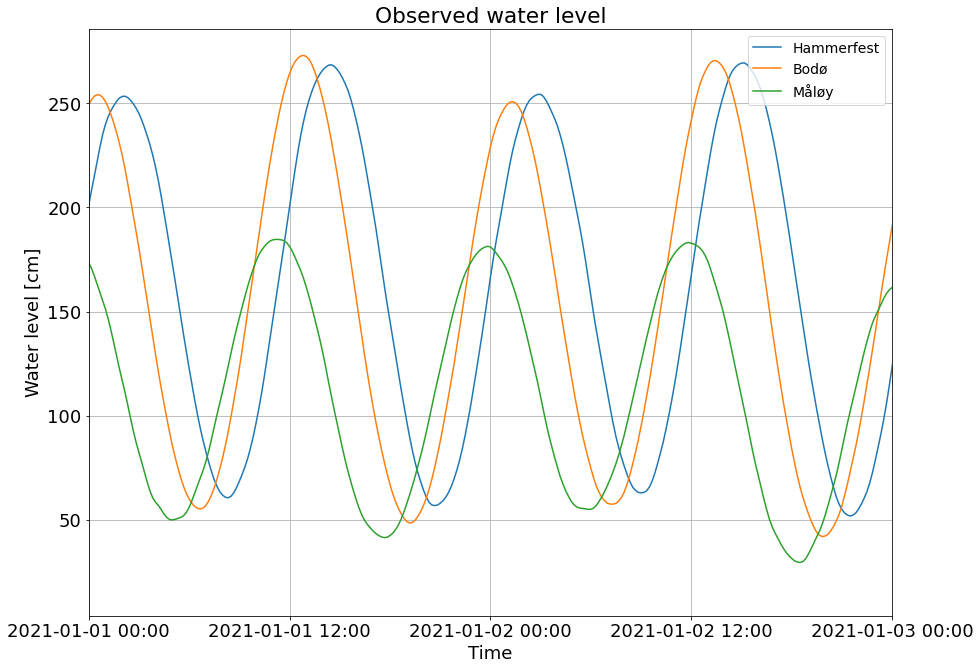

In [6]:
#--- Plot the data, but zoomed in to show the timing difference
fig, ax = plt.subplots(figsize=(14.4,10.8))
for i in range(len(stations)-1):
    # Add a new subplot for this station
    station = stations[i]
    plt.plot(df_stations[station]['Level'].loc['2021-01-01':'2021-01-03'], label=df_stations_info.loc[station]['name'])
    #axs[i].plot(df_stations[station]['regression'].loc['2011-01':'2011-03'], label='Modelled water level')
plt.ylabel('Water level [cm]')
plt.xlabel('Time')
plt.title('Observed water level')
plt.legend(loc='upper right',fontsize=14)
plt.grid(True)
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=(0, 12)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-01-03'));

In [7]:

#--- Calculate the tidal range, i.e. average difference between water level at high and low tide

# Use Scipy to identify the local maximums and minimums. Do not include the first and last min and max points, 
# since these points will be identified as local extrema, without necessarily corresponding to high or low tide.

for station in stations:
    df_stations[station]['min'] = df_stations[station].iloc[argrelextrema(
        df_stations[station]['Level'].values, np.less_equal, order=24
        )[0]]['Level'][1:-1]
    df_stations[station]['max'] = df_stations[station].iloc[argrelextrema(
        df_stations[station]['Level'].values, np.greater_equal, order=24
        )[0]]['Level'][1:-1]

# Filter the 'max' and 'min' series to get only the index of the actual high and low tides
high_tide_MAY = df_stations['MAY']['max'][~np.isnan(df_stations['MAY']['max'])]
high_tide_BOO = df_stations['BOO']['max'][~np.isnan(df_stations['BOO']['max'])]
high_tide_HFT = df_stations['HFT']['max'][~np.isnan(df_stations['HFT']['max'])]
high_tide_TRG = df_stations['TRG']['max'][~np.isnan(df_stations['TRG']['max'])]

low_tide_MAY = df_stations['MAY']['min'][~np.isnan(df_stations['MAY']['min'])]
low_tide_BOO = df_stations['BOO']['min'][~np.isnan(df_stations['BOO']['min'])]
low_tide_HFT = df_stations['HFT']['min'][~np.isnan(df_stations['HFT']['min'])]
low_tide_TRG = df_stations['TRG']['min'][~np.isnan(df_stations['TRG']['min'])]


# It could be that two consecutive time steps have the same value and are both identified as the timing of the high tide. 
# Make sure this is not the case by ensuring there are at least 6 hours between two identified maxima.
high_tide_MAY_filter = high_tide_MAY.index[high_tide_MAY.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
high_tide_BOO_filter = high_tide_BOO.index[high_tide_BOO.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
high_tide_HFT_filter = high_tide_HFT.index[high_tide_HFT.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
high_tide_TRG_filter = high_tide_TRG.index[high_tide_TRG.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]

low_tide_MAY_filter = low_tide_MAY.index[low_tide_MAY.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
low_tide_BOO_filter = low_tide_BOO.index[low_tide_BOO.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
low_tide_HFT_filter = low_tide_HFT.index[low_tide_HFT.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
low_tide_TRG_filter = low_tide_TRG.index[low_tide_TRG.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]

high_tide_MAY_2 = high_tide_MAY[high_tide_MAY_filter]
high_tide_BOO_2 = high_tide_BOO[high_tide_BOO_filter]
high_tide_HFT_2 = high_tide_HFT[high_tide_HFT_filter]
high_tide_TRG_2 = high_tide_TRG[high_tide_TRG_filter]

low_tide_MAY_2 = low_tide_MAY[low_tide_MAY_filter]
low_tide_BOO_2 = low_tide_BOO[low_tide_BOO_filter]
low_tide_HFT_2 = low_tide_HFT[low_tide_HFT_filter]
low_tide_TRG_2 = low_tide_TRG[low_tide_TRG_filter]

tidal_range_HFT = high_tide_HFT_2.values - low_tide_HFT_2.values[1:]
tidal_range_BOO = high_tide_BOO_2.values - low_tide_BOO_2.values
tidal_range_MAY = high_tide_MAY_2.values - low_tide_MAY_2.values
tidal_range_TRG = high_tide_TRG_2.values[:-1] - low_tide_TRG_2.values

# Print the mean tidal range
print(f'Station    Mean tidal range [cm]')
print(f'HFT {tidal_range_HFT.mean():17.2f}')
print(f'BOO {tidal_range_BOO.mean():17.2f}')
print(f'MAY {tidal_range_MAY.mean():17.2f}')
print(f'TRG {tidal_range_TRG.mean():17.2f}')


Station    Mean tidal range [cm]
HFT            181.68
BOO            181.48
MAY            119.98
TRG             21.49


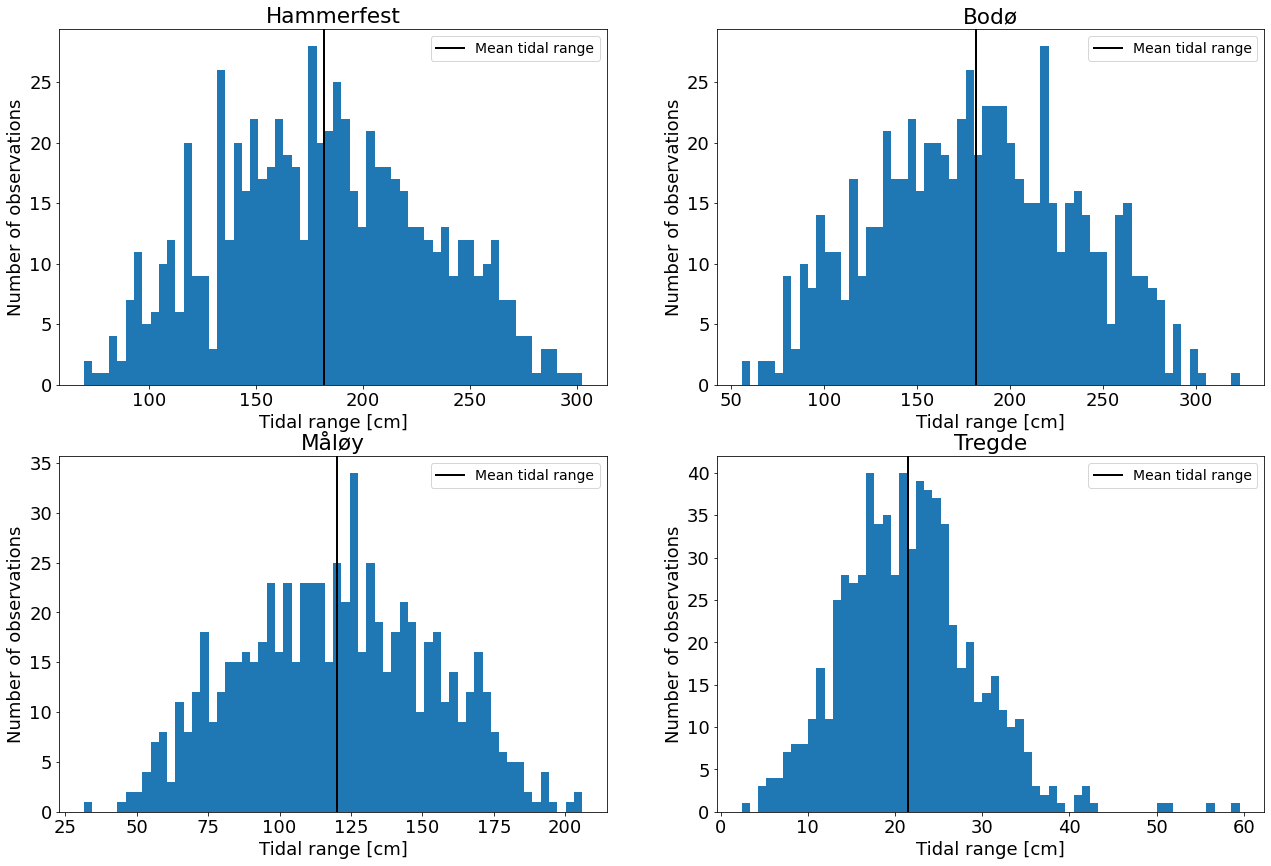

In [8]:
# Make histograms of the tidal ranges
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(21.6,14.4))
axs[0,0].hist(tidal_range_HFT, bins=60)
axs[0,0].axvline(tidal_range_HFT.mean(), lw=2.0, color='black', label='Mean tidal range')
axs[0,0].set_title('Hammerfest')
axs[0,0].set_xlabel('Tidal range [cm]')
axs[0,0].set_ylabel('Number of observations')
axs[0,0].legend(fontsize=14)

axs[0,1].hist(tidal_range_BOO, bins=60)
axs[0,1].axvline(tidal_range_BOO.mean(), lw=2.0, color='black', label='Mean tidal range')
axs[0,1].set_title('Bodø')
axs[0,1].set_xlabel('Tidal range [cm]')
axs[0,1].set_ylabel('Number of observations')
axs[0,1].legend(fontsize=14)

axs[1,0].hist(tidal_range_MAY, bins=60)
axs[1,0].axvline(tidal_range_MAY.mean(), lw=2.0, color='black', label='Mean tidal range')
axs[1,0].set_title('Måløy')
axs[1,0].set_xlabel('Tidal range [cm]')
axs[1,0].set_ylabel('Number of observations')
axs[1,0].legend(fontsize=14)

axs[1,1].hist(tidal_range_TRG, bins=60)
axs[1,1].axvline(tidal_range_TRG.mean(), lw=2.0, color='black', label='Mean tidal range')
axs[1,1].set_title('Tregde')
axs[1,1].set_xlabel('Tidal range [cm]')
axs[1,1].set_ylabel('Number of observations')
axs[1,1].legend(fontsize=14);


In [9]:
# Calculate and print the mean tidal range
tidal_range = {}
print(f'Station    Mean tidal range [cm]')
for station in stations:
    tidal_range[station] = df_stations[station]['max'].mean() - df_stations[station]['min'].mean()
    print(f'{station} {tidal_range[station]:17.2f}')

Station    Mean tidal range [cm]
HFT            180.61
BOO            180.02
MAY            119.15
TRG             21.59


In [10]:
#--- Calculate the time lag:
# Knowing that there are no missing data, the time series for all stations are "perfect"

# Filter the 'max' and 'min' series to get only the index of the actual high and low tides
high_tide_MAY = df_stations['MAY']['max'][~np.isnan(df_stations['MAY']['max'])]
high_tide_BOO = df_stations['BOO']['max'][~np.isnan(df_stations['BOO']['max'])]
high_tide_HFT = df_stations['HFT']['max'][~np.isnan(df_stations['HFT']['max'])]

# It could be that two consecutive time steps have the same value and are both identified as the timing of the high tide. 
# Make sure this is not the case by ensuring there are at least 6 hours between two identified maxima.
high_tide_MAY_filtered = high_tide_MAY.index[high_tide_MAY.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
high_tide_BOO_filtered = high_tide_BOO.index[high_tide_BOO.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]
high_tide_HFT_filtered = high_tide_HFT.index[high_tide_HFT.index.to_series().diff() > pd.Timedelta(seconds=60*60*6)]

# calculate the time lag
time_lag_MAY_BOO = (high_tide_BOO_filtered - high_tide_MAY_filtered).mean()
time_lag_MAY_HFT = (high_tide_HFT_filtered - high_tide_MAY_filtered).mean()
time_lag_BOO_HFT = (high_tide_HFT_filtered - high_tide_BOO_filtered).mean()

# Calculate and print the time lag
print('Time lag between MAY and BOO:', time_lag_MAY_BOO)
print('Time lag between MAY and HFT:', time_lag_MAY_HFT)
print('Time lag between BOO and HFT:', time_lag_BOO_HFT)

Time lag between MAY and BOO: 0 days 01:28:55.988620199
Time lag between MAY and HFT: 0 days 03:09:19.886201991
Time lag between BOO and HFT: 0 days 01:40:23.897581792


In [11]:
#--- Use the time lag to calculate the propagation speed of the tidal wave
d_MAY_BOO = 750    # Distance between MAY and BOO in km, estimated from Google Earth
d_BOO_HFT = 650    # Distance between BOO and HFT in km, estimated from Google Earth

# Calculate the propagation speed
speed_MAY_BOO = d_MAY_BOO / (time_lag_MAY_BOO.total_seconds()/(60*60))
speed_BOO_HFT = d_BOO_HFT / (time_lag_BOO_HFT.total_seconds()/(60*60))

# Print the results
print(f'Propagation speed of the tidal wave between MAY and BOO: {speed_MAY_BOO:.2f}')
print(f'Propagation speed of the tidal wave between BOO and HFT: {speed_BOO_HFT:.2f}')

Propagation speed of the tidal wave between MAY and BOO: 506.00
Propagation speed of the tidal wave between BOO and HFT: 388.45


In [12]:
#-----------------------------------------------------------------------------#
# Perform multiple regression to find the most important tidal constituents for each station
#-----------------------------------------------------------------------------#

# Define some parameters
alpha = 0.05        # Significance level

# Initialize a dictionarie to hold the results
results = {}        # Results of the multiple regression

#--- Prepare for the regression
# Read tidal constituents from file
#tidal_constituents = pd.read_csv('tidal_harmonics_2.txt', sep=' ', usecols=['NAME', 'FREQUENCY'], index_col='NAME')
# Calculate the angular velocity of the tidal constituents from the frequency
#tidal_constituents['Angular Speed (degrees/hour)'] = 360 * tidal_constituents['FREQUENCY']

# Read tidal constituents from file
tidal_constituents = pd.read_excel('tidal_harmonics.xlsx', index_col=0)

# Perform the regression
for station in stations:
    print(f'Performing multiple regression for station {station}')
    results[station] = multiple_regression(df_stations[station], tidal_constituents, alpha)


Performing multiple regression for station HFT
Regression nr. 1, most important constituent: M2
Regression nr. 2, most important constituent: S2
Regression nr. 3, most important constituent: N2
Regression nr. 4, most important constituent: K2
Regression nr. 5, most important constituent: K1
Regression nr. 6, most important constituent: Sa
Regression nr. 7, most important constituent: V2
Regression nr. 8, most important constituent: Ssa
Regression nr. 9, most important constituent: O1
Regression nr. 10, most important constituent: Mm
Regression nr. 11, most important constituent: _2N2
Regression nr. 12, most important constituent: MU2
Adding the tidal constituent MU2 does not significantly improve the regression. The regression is ended here.
Performing multiple regression for station BOO
Regression nr. 1, most important constituent: M2
Regression nr. 2, most important constituent: S2
Regression nr. 3, most important constituent: N2
Regression nr. 4, most important constituent: K1
Regre

In [13]:
# Print some results of the regressions
for station in stations:
    n = len(results[station]["list_of_most_important_constituents"])    # Number of significant tidal constituents

    print(f'Station {station}:')
    print(f' Number of significant tidal constituents: {n}')
    print(f' Significant tidal constituents: {results[station]["list_of_most_important_constituents"]}')
    print(f' R^2 for the full regression: {results[station][f"regression_{n}"]["R2"]:.3f}')
    print()

Station HFT:
 Number of significant tidal constituents: 11
 Significant tidal constituents: ['M2', 'S2', 'N2', 'K2', 'K1', 'Sa', 'V2', 'Ssa', 'O1', 'Mm', '_2N2']
 R^2 for the full regression: 0.959

Station BOO:
 Number of significant tidal constituents: 15
 Significant tidal constituents: ['M2', 'S2', 'N2', 'K1', 'Sa', 'K2', 'Mm', 'Ssa', 'O1', 'V2', 'P1', 'MSf', 'M4', '_2N2', 'MU2']
 R^2 for the full regression: 0.955

Station MAY:
 Number of significant tidal constituents: 10
 Significant tidal constituents: ['M2', 'S2', 'Sa', 'N2', 'K2', 'O1', 'Mm', 'K1', 'Ssa', 'MSf']
 R^2 for the full regression: 0.907

Station TRG:
 Number of significant tidal constituents: 4
 Significant tidal constituents: ['M2', 'Sa', 'Mm', 'MSf']
 R^2 for the full regression: 0.385



In [14]:
# Print the R2 for the regressions with only 1 and 2 tidal constituents
print('HFT:', results['HFT']['regression_1']["R2"])
print('BOO:', results['BOO']['regression_1']["R2"])
print('MAY:', results['MAY']['regression_1']["R2"])
print('TRG:', results['TRG']['regression_1']["R2"])
print()
print('HFT:', results['HFT']['regression_2']["R2"])
print('BOO:', results['BOO']['regression_2']["R2"])
print('MAY:', results['MAY']['regression_2']["R2"])
print('TRG:', results['TRG']['regression_2']["R2"])

HFT: 0.8150347009887537
BOO: 0.7786583857227696
MAY: 0.7192895682556792
TRG: 0.19732080118324669

HFT: 0.8960370256881611
BOO: 0.876178141959744
MAY: 0.8056905436347298
TRG: 0.3386218666496432


In [15]:
# Calculate the full regression time series for each station
amplitudes = {}
phases = {}
intercepts = {}

for station in stations:
    amplitudes[station] = {}
    phases[station] = {}
    n = len(results[station]["list_of_most_important_constituents"])    # Number of significant tidal constituents
    # Initialize the regression with the intercept
    regression = results[station][f'regression_{n}']['params']['Intercept']
    intercepts[station] = results[station][f'regression_{n}']['params']['Intercept']
    # Loop over the constituents used in the regression for this station and add their contribution to the regression
    for constituent in results[station]['list_of_most_important_constituents']:
        regression += (
            results[station][f'regression_{n}']['params'][f'{constituent}_cos']
            * np.cos(np.deg2rad(tidal_constituents.loc[constituent]['Angular Speed (degrees/hour)']*df_stations[station]['tk']))
            + results[station][f'regression_{n}']['params'][f'{constituent}_sin']
            * np.sin(np.deg2rad(tidal_constituents.loc[constituent]['Angular Speed (degrees/hour)']*df_stations[station]['tk']))
        )
    # The regressions were done after removing the mean waterlevel from the time series. Add it again now.
    df_stations[station]['regression'] = regression + df_stations[station]['Level'].mean()
    
    # The above code calculates the regression from the rewritten expression, where A*cos(ai*t - phi) is spit into a cosine and a sine, A_i*cos(a_i*t - phi_i) = c_i*cos(a_i*t) + s_i*sin(a_i*t) 
    # We can also calculate the regression based on the original expression, by using that A_i = sqrt(c_i**2 + s_i**2) and phi_i = arctan(s_i / c_i).
    # These two regressions should, of course, be the same so it's a good check.
    # Initialize the regression2 with the intercept
    regression2 = results[station][f'regression_{n}']['params']['Intercept']
    # Loop over the constituents used in the regression for this station and add their contribution to the regression
    for constituent in results[station]['list_of_most_important_constituents']:
        amplitude = np.sqrt(
            results[station][f'regression_{n}']['params'][f'{constituent}_cos']**2
            + results[station][f'regression_{n}']['params'][f'{constituent}_sin']**2
        )
        phase = np.arctan2(
            results[station][f'regression_{n}']['params'][f'{constituent}_sin'],
            results[station][f'regression_{n}']['params'][f'{constituent}_cos']
        )
        # numpy arctan2 gives an angle in the range [-pi, pi], convert it to [0, 2pi]
        if phase < 0:
            phase += 2*np.pi
        regression2 += amplitude*np.cos(np.deg2rad(tidal_constituents.loc[constituent]['Angular Speed (degrees/hour)']*df_stations[station]['tk']) - phase)
        amplitudes[station][constituent] = amplitude
        phases[station][constituent] = np.rad2deg(phase)
    # The regressions were done after removing the mean waterlevel from the time series. Add it again now.
    df_stations[station]['regression2'] = regression2 + df_stations[station]['Level'].mean()


In [16]:
# Are the two regressions the same?
for station in stations:
    unequal = 0
    for i in range(int(len(df_stations[station]['regression'].index))):
        if round(df_stations[station]['regression'][i], 4) == round(df_stations[station]['regression2'][i], 4):
            continue
        else:
            unequal += 1
    if unequal == 0:
        print(f'{station}: The regressions are the same')
    else:
        print(f'{station}: There are {unequal} model points in the regressions that are not the same')

HFT: The regressions are the same
BOO: The regressions are the same
MAY: The regressions are the same
TRG: The regressions are the same


In [17]:
# Print the parameters from the regression
print('Station:', 'HFT')
print(' Intercept:', intercepts['HFT'])
print(' Amplitudes:', amplitudes['HFT'])
print(' Phases:', phases['HFT'])

Station: HFT
 Intercept: -1.1793566262604798
 Amplitudes: {'M2': 87.85463865863989, 'S2': 27.666366723060207, 'N2': 18.738831190169, 'K2': 8.67147877831687, 'K1': 8.360631920868311, 'Sa': 6.292295047319096, 'V2': 3.6204309911033135, 'Ssa': 3.578113331075538, 'O1': 3.476697899659883, 'Mm': 3.3298865156115856, '_2N2': 3.118441254087477}
 Phases: {'M2': 30.40811877999233, 'S2': 58.3083300026279, 'N2': 339.11982300013057, 'K2': 231.04275129987235, 'K1': 212.22892338737228, 'Sa': 307.2288180024508, 'V2': 44.61662534989289, 'Ssa': 185.2773931760612, 'O1': 58.56138785894326, 'Mm': 268.7888118056527, '_2N2': 288.68052766593377}


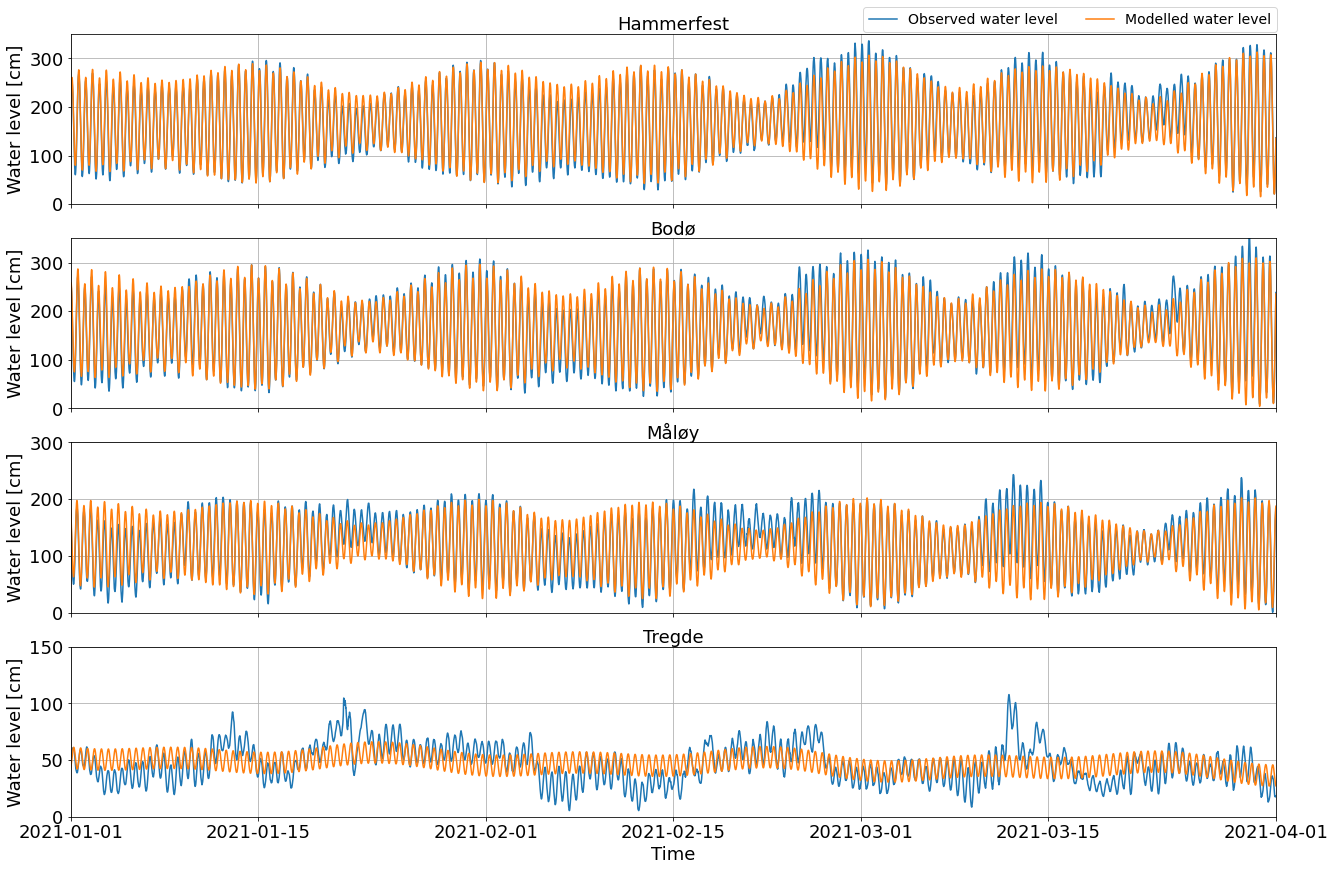

In [18]:
###
# Plot the regression and observations
###
ylims = [350, 350, 300, 150]
fig, axs = plt.subplots(4, 1, sharex='all', figsize=(21.6,14.4))
for i in range(len(stations)):
    # Add a new subplot for this station
    station = stations[i]
    axs[i].plot(df_stations[station]['Level'].loc['2021-01':'2021-03'], label='Observed water level')
    axs[i].plot(df_stations[station]['regression'].loc['2021-01':'2021-03'], label='Modelled water level')
    axs[i].set_ylabel('Water level [cm]')
    axs[i].text(0.5, 1, df_stations_info.loc[station]['name'], verticalalignment='bottom',
            horizontalalignment='center', transform=axs[i].transAxes, fontsize=18)
    axs[i].grid(True)
    axs[i].set_ylim([0, ylims[i]])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.829, 1.20), ncol=2, fontsize=14)
axs[-1].set_xlabel('Time')
axs[-1].set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-04-01'));


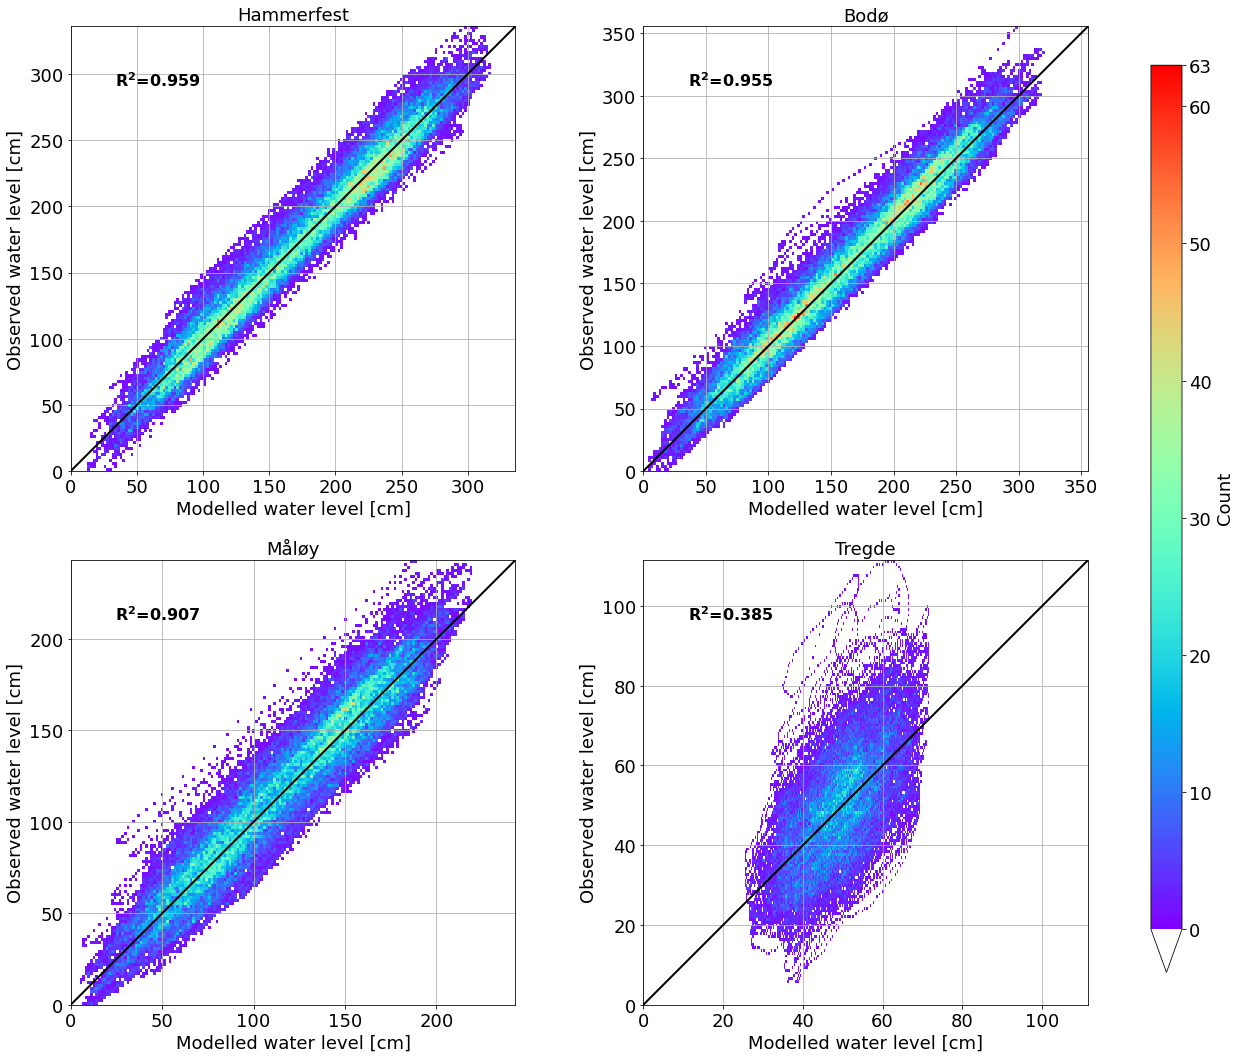

In [19]:
###
# Make scatterplots
###
# Initialize dictionaries to hold the data we need for the scatterplots
x = {}       # Modelled water level
y = {}       # Observed water level
H = {}       # Bi-dimensional histogram of observed and modelled water level
xedges = {}  # Bin edges along the x dimension
yedges = {}  # Bin edges along the y dimension

# Loop over the stations to count model-obs pairs in a set of bins
for station in stations:
    # Remove nan values
    x[station] = df_stations[station]['regression'][~np.isnan(df_stations[station]['regression'])].values
    y[station] = df_stations[station]['Level'][~np.isnan(df_stations[station]['Level'])].values
    x[station] = x[station][~np.isnan(y[station])]
    y[station] = y[station][~np.isnan(x[station])]
    # Compute the number of model-obs pairs in water level bins
    H[station], xedges[station], yedges[station] = np.histogram2d(x[station], y[station], bins=150)
    # According to the Numpy documentation H does not follow the Cartesian convention where x values are on the abscissa and y values on the ordinate axis.
    # Therefore, we transpose H for plotting
    H[station] = H[station].T
    # Set the bins with no pairs to nan, so they will be white in the plot
    H[station][H[station]==0] = np.nan

# Adjust the color map for the plotting so that bins with no model-obs pairs will be white
palette = plt.get_cmap('rainbow').copy()
palette.set_bad("white")
palette.set_under("white", 1.0)
# Find the maximum number of model-obs pair in any bin, so the color scale will the same in all the scatterplots
H_max = np.max([H[station][~np.isnan(H[station])].max() for station in stations])

# Plot
###### NEED A SUPTITLE FOR THIS FIGURE!!!
fig = plt.figure(figsize=(21.6,18))
for i in range(len(stations)):
    # Add a new subplot for the station
    station = stations[i]
    ax = plt.subplot(2,2, i + 1, aspect='equal')
    im = ax.pcolormesh(xedges[station], yedges[station], H[station], vmin=0, vmax=H_max, cmap=palette)
    # Find the maximum water level value observed or modelled to use as axis limit
    axis_max = np.max([x[station].max(), y[station].max()])
    # Plot a straight line for the perfect fit
    line = np.linspace(0, axis_max, 1000)
    ax.plot(line, line, color='k', lw=2.0)
    # Format the plot by adding title, axis labels etc.
    ax.set_xlim(0, axis_max)
    ax.set_ylim(0, axis_max)
    ax.set_title(df_stations_info.loc[station]['name'], fontsize=18)
    ax.set_xlabel('Modelled water level [cm]')
    ax.set_ylabel('Observed water level [cm]')
    ax.grid()
    # Write the R^2 value for the regression
    n = len(results[station]["list_of_most_important_constituents"])
    R2 = results[station][f'regression_{n}']['R2']
    ax.text(0.1, 0.9, s=fr'$\mathbf{{R^{2}}}$={R2:.3f}', verticalalignment='top', 
             horizontalalignment='left', transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot the colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
cb = plt.colorbar(im, cax=cbar_ax, extend='min', ticks=[0, 10, 20, 30, 40, 50, 60, H_max]);
cb.set_label(label='Count', size=18)
